In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


In [0]:
ndf = pd.read_csv('Nifty50.csv')
ndf.Date = pd.to_datetime(ndf['Date'])

ndf['bollinger'] = ndf['Close'].rolling(14).mean()
std = ndf['Close'].rolling(14).std()
ndf['upper'] = ndf['bollinger'] + 2 * std 
ndf['lower'] = ndf['bollinger'] - 2 * std
ndf = ndf.dropna()

conditions = [
    (ndf.Open < ndf['lower']),
    (ndf.Open > ndf['lower']) & (ndf.Open < ndf["bollinger"]),
    (ndf.Open < ndf['upper']) & (ndf.Open > ndf["bollinger"]),
    (ndf.Open > ndf['upper'])
    ]

choices = ['Buy', 'Hold Buy', 'Hold Short', "Short"]
ndf["Call"] = np.select(conditions, choices) 
# print(ndf.head(10))


In [0]:
from sklearn.model_selection import train_test_split

X = ndf[['lower','bollinger', 'upper']].values
Y = ndf["Call"].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(4, n_jobs=-1)
knn.fit(X_train, Y_train)

print("KNN\'s Score = ", knn.score(X_test, Y_test)) 


KNN's Score =  0.6


In [0]:

from sklearn import svm

clf = svm.SVC(gamma='auto', decision_function_shape='ovo')
clf.fit(X_train, Y_train)
print("SVM\'s Score = ", clf.score(X_test, Y_test)) 


SVM's Score =  0.6206896551724138


In [0]:

from sklearn import tree

tree = tree.DecisionTreeClassifier().fit(X_train, Y_train)
print("Tree\'s Score", tree.score(X_test, Y_test))


Tree's Score 0.6068965517241379


In [0]:

hdf = pd.read_csv('HEROMOTOCO.csv')
hdf = hdf[hdf["Series"] == "EQ"]
hdf.Date = pd.to_datetime(hdf['Date'])

hdf['bollinger'] = hdf['Close Price'].rolling(14).mean()
std = hdf['Close Price'].rolling(14).std()
hdf['upper'] = hdf['bollinger'] + 2 * std 
hdf['lower'] = hdf['bollinger'] - 2 * std
hdf = hdf.dropna()

# Using SVM Model
X = hdf[['lower','bollinger', 'upper']].values
hdf["Call Pridicted"] = clf.predict(X)
print(hdf[["Open Price", 'bollinger', 'upper', 'lower', 'Call Pridicted']].head(5))


    Open Price    bollinger        upper        lower Call Pridicted
13     3742.00  3627.767857  3770.667357  3484.868357     Hold Short
14     3758.80  3651.646429  3822.656129  3480.636728     Hold Short
15     3850.00  3667.042857  3862.597846  3471.487868     Hold Short
16     3844.00  3678.042857  3885.452596  3470.633118     Hold Short
17     3803.85  3695.985714  3914.513996  3477.457433     Hold Short


In [0]:


ndf = pd.read_csv('Nifty50.csv')
ndf.Date = pd.to_datetime(ndf['Date'])
ndf = ndf.set_index('Date')

ndf['pctch_open_close'] = (ndf.Close - ndf.Open)/ndf.Open *100
ndf['pctch_low_high'] = (ndf.High - ndf.Low)/ndf.Low *100
ndf['rolling_mean5'] = ndf['Close'].rolling(5).mean()
ndf["std5"] = ndf['Close'].rolling(5).std()

l=[]
for i in range(ndf.Close[:-1].shape[0]):
    if ndf.Close[i] < ndf.Close[i+1]:
        l.append(1)
    elif ndf.Close[i] > ndf.Close[i+1]:
        l.append(-1)
    else: 
        l.append("NaN")
l.append('NaN')

ndf["Action"] = np.array([l]).reshape((len(l),1))
ndf = ndf.dropna()

X = ndf[['pctch_open_close', 'pctch_low_high', 'rolling_mean5', "std5"]].values
Y = ndf.Action.values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [0]:

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

random_forest = RandomForestClassifier(n_estimators=50, random_state=42)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)

print("Accuracy:",metrics.accuracy_score(Y_pred, Y_test))


Accuracy: 0.5714285714285714


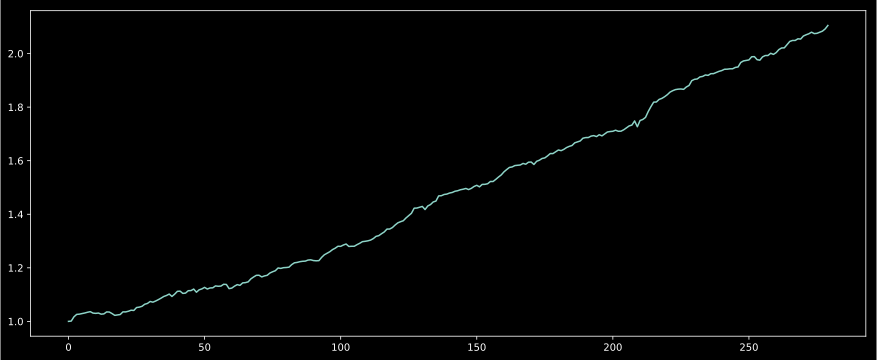

In [0]:

pridicted_Y = random_forest.predict(X)[:-1].astype('int')
pridicted_Y = np.hstack((1, pridicted_Y))

raw = np.array([i*j for i, j in zip(pridicted_Y, ndf.Close)]) 

temp = [1, ]

for i in range(1, len(pridicted_Y)):
    if pridicted_Y[i] < 1:
        continue    
    else:
        profit = (ndf.Close[i] - abs(ndf.Close[i-1])) / abs(ndf.Close[i-1])
        temp.append(profit)


returns_perc = []
for i in range(1, len(temp)):
    returns_perc.append(np.sum(temp[:i]))

fig, ax  = plt.subplots(figsize=(15, 6))
ax.plot(range(len(returns_perc)), returns_perc)
plt.show()
